Name: Allan Bil Faqih

NPM: 5210411383

In [1]:
!git clone https://github.com/allanbil214/facerecog_lbp.git

Cloning into 'facerecog_lbp'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 419 (delta 19), reused 46 (delta 7), pack-reused 345
Receiving objects: 100% (419/419), 280.73 MiB | 34.91 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (249/249), done.


# Import libraries

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# Face Detection

In [3]:
training_data_folder_path = '/content/facerecog_lbp/train'
test_data_folder_path = '/content/facerecog_lbp/test'

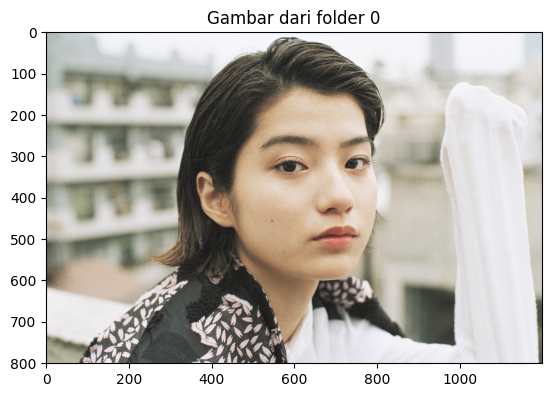

In [4]:
read_image = cv2.imread('/content/facerecog_lbp/train/0/makita_24.jpg')
image=cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB)
plt.title('Gambar dari folder 0')
plt.imshow(image)

In [5]:
# Load LBP XML File
lbpcascade_frontalface = '/content/facerecog_lbp/lbp/lbpcascade_frontalface_improved.xml'

In [6]:
def detect_faces(input_img):
    # Convert image to grayscale
    img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    # Load face cascade classifier
    face_cascade = cv2.CascadeClassifier(lbpcascade_frontalface)

    # Detect faces using multi-scale
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.2, minNeighbors=5);

    # If no faces detected, return None
    if (len(faces) == 0):
        return None, None

    # Extract the face region
    (x, y, w, h) = faces[0]
    # Return only the face region of the image
    return img[y:y+w, x:x+h], faces[0]

# Training Data Preparation

In [7]:
def prepare_training_data(training_data_folder_path):
    # Lists to hold detected faces and their corresponding labels
    detected_faces = []
    labels = []

    # Get the list of subdirectories (each subdirectory represents a class)
    class_directories = [os.path.join(training_data_folder_path, dir_name) for dir_name in os.listdir(training_data_folder_path) if os.path.isdir(os.path.join(training_data_folder_path, dir_name))]

    # Initialize tqdm progress bar
    pbar = tqdm(total=len(class_directories), desc='Processing Images', unit='dir')

    # Traverse each class directory
    for class_dir in class_directories:
        # Extract label from directory name
        label = int(os.path.basename(class_dir))

        # Get the list of image files in the class directory
        image_files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file)) and (file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'))]

        # Initialize tqdm progress bar for images in the current class directory
        pbar_images = tqdm(total=len(image_files), desc=f'Class {label}', unit='img', leave=False)

        # Traverse each image file in the class directory
        for image_file in image_files:
            # Read the image
            img = cv2.imread(os.path.join(class_dir, image_file))

            # Detect faces in the image
            face, _ = detect_faces(img)

            # If face is detected, add it to the list along with its label
            if face is not None:
                detected_faces.append(face)
                labels.append(label)

            # Update tqdm progress bar
            pbar_images.update(1)

        # Close tqdm progress bar for images in the current class directory
        pbar_images.close()

        # Update tqdm progress bar
        pbar.update(1)

    # Close tqdm progress bar
    pbar.close()

    return detected_faces, labels


In [8]:
detected_faces, label_faces = prepare_training_data(training_data_folder_path)

Processing Images: 100%|██████████| 3/3 [01:05<00:00, 21.76s/dir]


In [17]:
print("Total faces: ", len(detected_faces))
print("Total lable: ", len(label_faces))

Total faces:  80
Total lable:  80


In [10]:
# Create LBPH face recognizer
lbphfaces_recognizer=cv2.face.LBPHFaceRecognizer_create(radius=1, neighbors=2)

# Initiate Face Detection

In [11]:
# Training
lbphfaces_recognizer.train(detected_faces, np.array(label_faces))

# Training Face Detection Model

In [12]:
# Function to draw a rectangle on the image
# according to the given (x, y) coordinates and provided width and height
def draw_rectangle(test_image, rectangle):
    # Extracting rectangle coordinates and dimensions
    (x, y, w, h) = rectangle
    # Drawing a rectangle on the image
    cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Function to draw text on the given image starting from the (x, y) coordinate.
def draw_text(test_image, label_text, x, y):
    # Drawing text on the image
    cv2.putText(test_image, label_text, (x, y), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255, 255, 255), 2)


# Predict the result using trained model

In [13]:
def predict(test_image):
    # Detect face in the test image
    chosen_face, rectangle = detect_faces(test_image)

    # Predict the label of the detected face based on the trained model
    label = lbphfaces_recognizer.predict(chosen_face)

    # Get the corresponding text label for the predicted label
    label_text = tags[label[0]]

    # Draw rectangle and text around the detected face
    draw_rectangle(test_image, rectangle)
    draw_text(test_image, label_text, rectangle[0], rectangle[1]-5)

    # Return the modified test image with the detected face and the predicted label
    return test_image, label_text

In [48]:
tags = ['Makita', 'Riho', "Chalamet"]
test_image = cv2.imread('/content/tmp_MBScqF_3b5d6da8b5b44b23_GettyImages-1180163474-2984610384.jpg')
img_predict, label = predict(test_image)

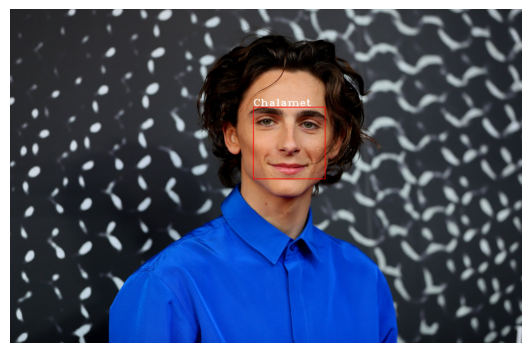

In [49]:
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
plt.axis("off")
imgplot = plt.imshow(cv2.cvtColor(img_predict, cv2.COLOR_BGR2RGB))
plt.show()

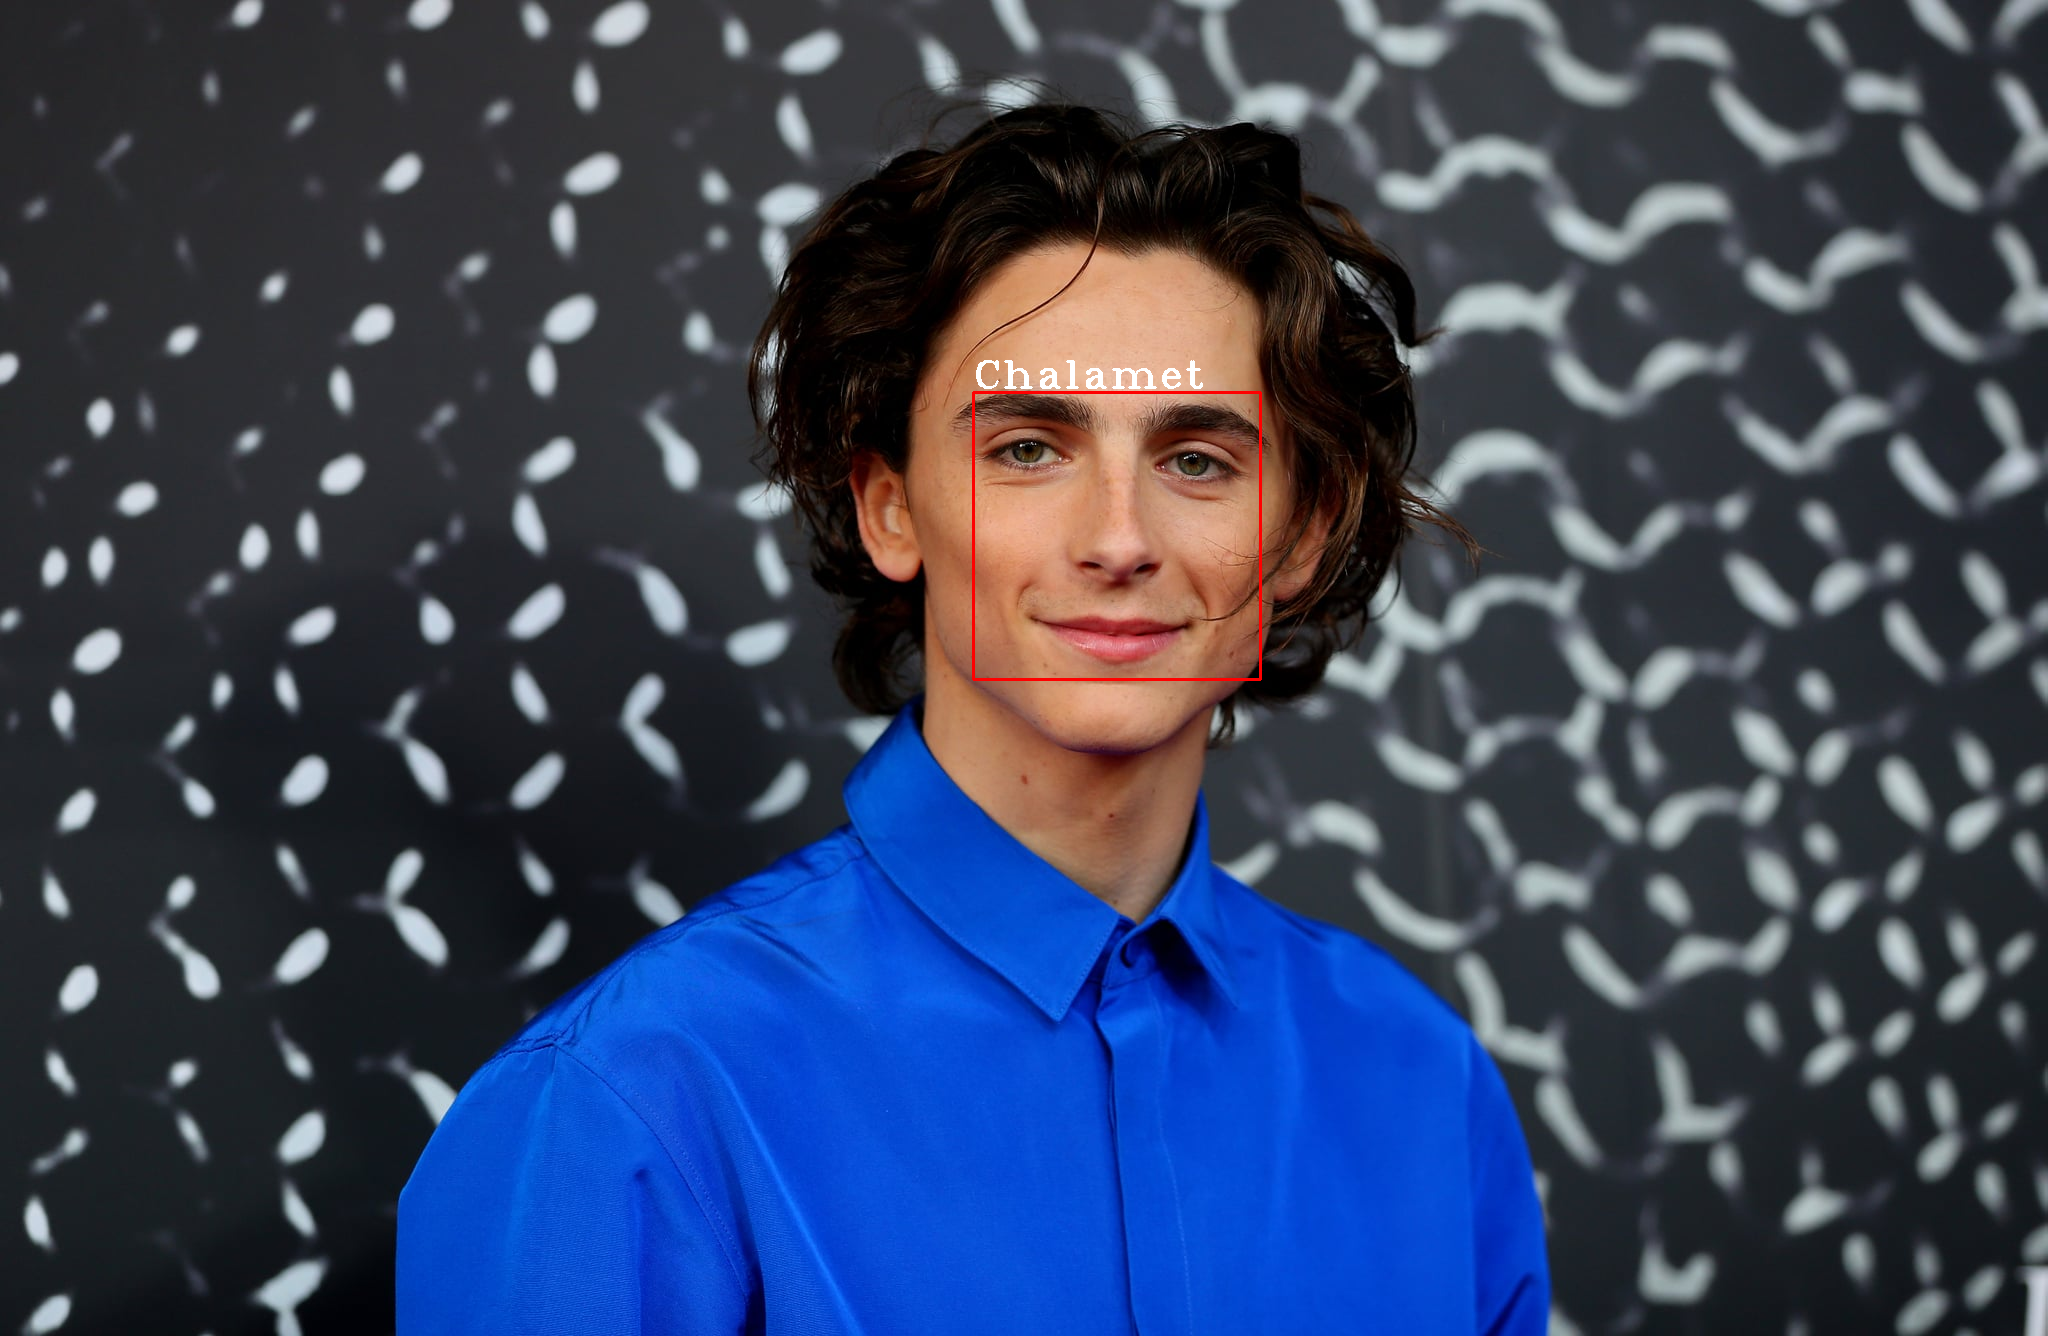

In [50]:
cv2_imshow(img_predict)